In [1]:
# Cell 1: Import libraries and set seeds for reproducibility
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import cv2
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [2]:
# Cell 2: Load dataset metadata and split data into train, validation, and test sets
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Load the CSV files
labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

# Merge on 'patientId' and simplify labels
merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

# Create train (80%) and validation (20%) splits (add test split if needed)
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=SEED, stratify=labels_simple['Target'])

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 21347
Validation samples: 5337


In [3]:
# Cell 3: Define a function to load and preprocess DICOM images
# The function reads the DICOM file, normalizes the pixel values, resizes to (224,224), and converts the image to 3-channel RGB.
def load_preprocess_dicom(dicom_path, img_size=(224, 224)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image to desired dimensions
    img_resized = cv2.resize(img_norm, img_size)
    # Convert grayscale to RGB by stacking channels
    img_rgb = np.stack([img_resized] * 3, axis=-1)
    return img_rgb

# Test the function on a sample image
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape (should be 224x224x3):", sample_img.shape)


✅ Sample image shape (should be 224x224x3): (224, 224, 3)


In [4]:
# Cell 4: Create data generators for training and validation
# We create an infinite generator for training (using an infinite loop) and a finite generator for validation.
def data_generator(df, batch_size=64, img_size=(224, 224), infinite=True):
    def gen():
        if infinite:
            while True:
                # Shuffle the DataFrame each epoch for randomness
                shuffled_df = df.sample(frac=1).reset_index(drop=True)
                for _, row in shuffled_df.iterrows():
                    patient_id = row['patientId']
                    label = 1 if row['Target'] == 'Pneumonia' else 0
                    dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                    img = load_preprocess_dicom(dicom_path, img_size)
                    yield img, label
        else:
            for _, row in df.iterrows():
                patient_id = row['patientId']
                label = 1 if row['Target'] == 'Pneumonia' else 0
                dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                img = load_preprocess_dicom(dicom_path, img_size)
                yield img, label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 3), ())
    )
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64
train_ds = data_generator(train_df, batch_size=BATCH_SIZE, infinite=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, infinite=False)

print("✅ Data generators created with batch size:", BATCH_SIZE)


✅ Data generators created with batch size: 64


In [5]:
# Cell 5: Build the DenseNet201 model with frozen base layers (transfer learning stage 1)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load DenseNet201 with ImageNet weights, excluding the top classifier layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the entire base model
base_model.trainable = False

# Build the complete model by adding a global average pooling layer and a custom classifier head
from tensorflow.keras.models import Sequential

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         245,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,568,001 (70.83 MB)

 Trainable params: 246,017 (961.00 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [6]:
# Cell 6: Compute class weights to mitigate class imbalance
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}
print("✅ Class weights:", class_weights)


✅ Class weights: {0: 0.6454314567333858, 1: 2.219022869022869}


In [7]:
# Cell 7: Define callbacks (EarlyStopping and ReduceLROnPlateau)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("✅ Callbacks defined.")


✅ Callbacks defined.


In [8]:
# Cell 8: Train the DenseNet201 model with frozen base (initial training of classifier head)
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch)

EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Steps per epoch: 334
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6902 - loss: 0.6008

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.6903 - loss: 0.6006 - val_accuracy: 0.7358 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 309s 928ms/step - accuracy: 0.7281 - loss: 0.5311 - val_accuracy: 0.6910 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 311s 933ms/step - accuracy: 0.7328 - loss: 0.5142 - val_accuracy: 0.7377 - val_loss: 0.5231 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.7482 - loss: 0.5015
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
334/334 ━━━━━━━━━━━━━━━━━━━━ 311s 933ms/step - accuracy: 0.7482 - loss: 0.5015 - val_accuracy: 0.7216 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 305s 914ms/step - accuracy: 0.7418 - loss: 0.4999 - val_accuracy: 0.7825 - val_loss: 0.4447 - learning_rate: 5.0000e-04
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 286s 859ms/step - accuracy: 0.7603 - 

In [9]:
# Cell 9: Unfreeze the DenseNet201 base for fine-tuning (stage 2)
# We can choose to unfreeze all layers or only the top few layers. Here, we unfreeze all layers.
base_model.trainable = True

# Optionally, freeze the first few layers (for example, freeze layers before a specific index)
# fine_tune_at = 300  # Uncomment to freeze layers before index 300
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
# for layer in base_model.layers[fine_tune_at:]:
#     layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("✅ Base model layers unfrozen for fine-tuning.")


✅ Base model layers unfrozen for fine-tuning.


In [10]:
# Cell 10: Fine-tune the model with the unfrozen base layers
# Continue training for additional epochs (fine-tuning stage)
FINE_TUNE_EPOCHS = 10  # You can adjust this as needed

fine_tune_history = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - accuracy: 0.7344 - loss: 0.5417 - val_accuracy: 0.7564 - val_loss: 0.4952 - learning_rate: 1.0000e-05
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7988 - loss: 0.4097 - val_accuracy: 0.7553 - val_loss: 0.5034 - learning_rate: 1.0000e-05
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8494 - loss: 0.3190 - val_accuracy: 0.7995 - val_loss: 0.4317 - learning_rate: 1.0000e-05
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 331s 993ms/step - accuracy: 0.9194 - loss: 0.1975 - val_accuracy: 0.8143 - val_loss: 0.4814 - learning_rate: 1.0000e-05
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 321s 962ms/step - accuracy: 0.9711 - loss: 0.0944 - val_accuracy: 0.8141 - val_loss: 0.5473 - learning_rate: 1.0000e-05
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9915 - loss: 0.0455
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
334/334 ━━━━━━━━━━━━━━━━━━━━ 298s 893ms/step 

84/84 ━━━━━━━━━━━━━━━━━━━━ 62s 609ms/step - accuracy: 0.8022 - loss: 0.4264
Validation Loss: 0.4317, Validation Accuracy: 0.7995


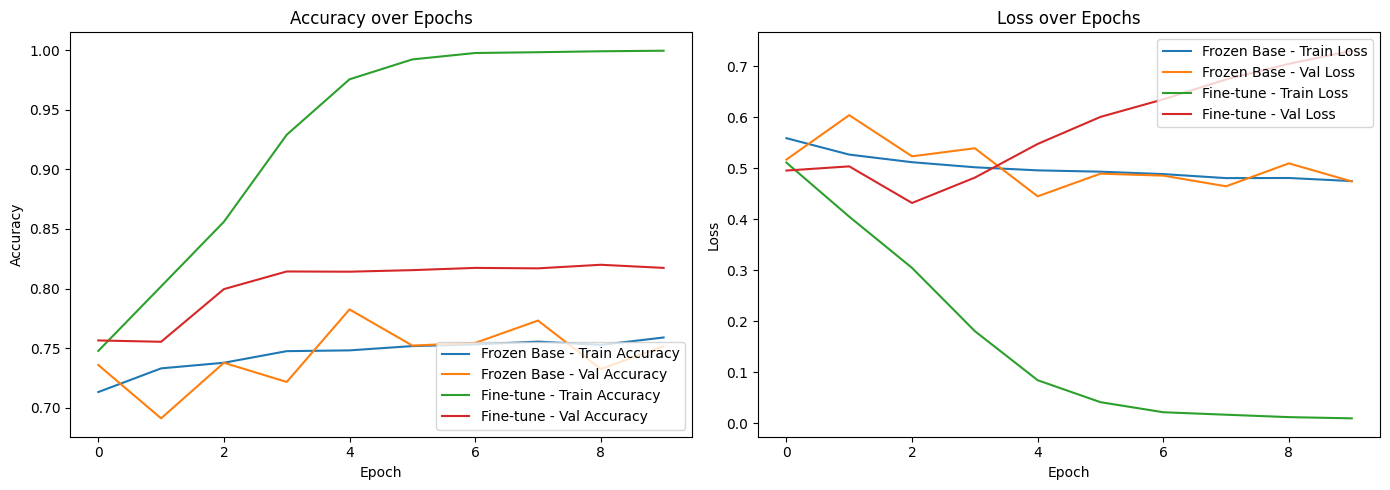

In [11]:
# Cell 11: Evaluate the fine-tuned model and plot learning curves
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot training curves from initial training and fine-tuning
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Frozen Base - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Frozen Base - Val Accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tune - Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tune - Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Frozen Base - Train Loss')
plt.plot(history.history['val_loss'], label='Frozen Base - Val Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-tune - Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tune - Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━

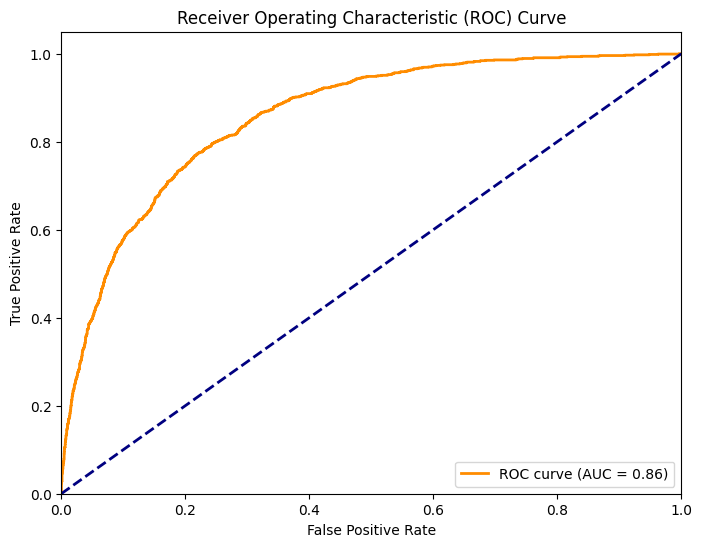

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Initialize lists to store ground truth and predictions
y_true = []
y_pred = []
y_scores = []  # Predicted probabilities

# Iterate over the validation dataset
for images, labels in val_ds:
    preds = model.predict(images)  # 'model' is your fine-tuned model
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())  # Use 0.5 threshold to classify
    y_scores.extend(preds.flatten())

# Compute evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Print metrics
print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision: {:.2f}".format(prec))
print("Recall (Sensitivity): {:.2f}".format(rec))
print("F1-Score: {:.2f}".format(f1))
print("Confusion Matrix:\n", cm)
print("AUC: {:.2f}".format(roc_auc))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
